In [2]:
import os
import psycopg2
from dotenv import load_dotenv
import geopandas as gpd
import json
from shapely.geometry import Polygon
from rasterio.transform import from_origin
import numpy as np
import rasterio
from rasterio.enums import Resampling
from matplotlib import pyplot as plt

In [3]:
load_dotenv()

dbname = os.getenv('POSTGRES_DB')
dbuser = os.getenv('POSTGRES_USER')
dbpass = os.getenv('POSTGRES_PASSWORD')
dbhost = os.getenv('POSTGRES_HOST')
dbport = os.getenv('POSTGRES_PORT')

In [4]:
dbhost

'localhost'

In [5]:
users = []
conn = psycopg2.connect(f'dbname={dbname} user={dbuser} password={dbpass} host={dbhost} port={dbport}')
try:
    cur = conn.cursor()
    cur.execute('SELECT u.id, u.username, a.id_anp FROM "user" as u JOIN user_anp_relations as a ON u.id=a.id_user WHERE u.id > 2')
    users = cur.fetchall()
    cur = conn.close()
except Exception as e:
    print(str(e))
finally:
    conn.close()

In [6]:
users[:10]

[(3, 'gina.castillo@conanp.gob.mx', 145),
 (4, 'santiago.vazquez@undp.org', 145),
 (5, 'francisco.gaytan@undp.org', 145),
 (6, 'salvador.ramirez@undp.org', 145),
 (7, 'antonio.soto@conanp.gob.mx', 43),
 (3, 'gina.castillo@conanp.gob.mx', 43),
 (4, 'santiago.vazquez@undp.org', 43),
 (8, 'culminatus1@gmail.com', 43),
 (9, 'portillo@conanp.gob.mx', 57),
 (3, 'gina.castillo@conanp.gob.mx', 57)]

In [7]:
def get_utm_zone(longitude):
    return int((longitude + 180) / 6) + 1

In [8]:
conn = psycopg2.connect(f'dbname={dbname} user={dbuser} password={dbpass} host={dbhost} port={dbport}')
cur = conn.cursor()
try:
    for t in users:
        cur.execute(f'SELECT c.id_cell, c.id_colour, st_asgeojson(g.geom) as geom FROM colouration as c JOIN grid_1km as g ON c.id_cell=g.id WHERE c.id_user = {t[0]} and c.id_anp = {t[2]}')
        coulored_cells = cur.fetchall()
        if len(coulored_cells) > 0:
            colou_gdf = gpd.GeoDataFrame(coulored_cells, columns = ['id_cell', 'colour', 'geometry'])
            colou_gdf['geometry'] = colou_gdf['geometry'].apply(lambda x: json.loads(x))       
            colou_gdf['geometry'] = colou_gdf['geometry'].apply(lambda x: Polygon(x['coordinates'][0]))
            colou_gdf = colou_gdf.set_geometry('geometry')
            colou_gdf = colou_gdf.set_crs(epsg=4326)

            #centroid = colou_gdf.geometry.centroid.iloc[0]
            #utm_zone = get_utm_zone(centroid.x)
            #utm_crs = f'epsg:326{utm_zone:02d}' if centroid.y >= 0 else f'epsg:327{utm_zone:02d}'

            #colou_gdf = colou_gdf.to_crs(utm_crs)
            
            print('id_user =', t[0], ', id_anp =', t[2])
            print(colou_gdf.head())
            
            #resolution = 1000
            resolution = 0.009
            minx, miny, maxx, maxy = colou_gdf.total_bounds
            print(minx, miny, maxx, maxy)
            width = int((maxx - minx) / resolution) + 1
            height = int((maxy - miny) / resolution) +1
            transform = from_origin(minx, maxy, resolution, resolution)
            
            print('width =', width, ', height =', height)
            
            raster = np.zeros((height, width), dtype=np.uint8)
            for index, row in colou_gdf.iterrows():
                geom = row.geometry
                color = row['colour']
                for x, y in geom.exterior.coords:
                    col = int((x - minx) / resolution)
                    row = int((maxy - y) / resolution)
                    #print(col,row)
                    raster[row, col] = color
                    if 0 <= row < height and 0 <= col < width:
                        raster[row, col] = color
                    
            print('id_user =', t[0], ', id_anp =', t[2])
            
            with rasterio.open(
                f'output_raster_{t[0]}_{t[2]}.tif',
                'w',
                driver='GTiff',
                height=raster.shape[0],
                width=raster.shape[1],
                count=1,
                dtype=raster.dtype,
                crs=colou_gdf.crs,
                transform=transform,
            ) as dst:
                dst.write(raster, 1)
            print('id_user =', t[0], ', id_anp =', t[2])
            break
except Exception as e:
    print(str(e))
finally:
    cur = conn.close()
    conn.close()

id_user = 5 , id_anp = 145
   id_cell  colour                                           geometry
0  4747308       3  POLYGON ((-99.909 16.875, -99.909 16.884, -99....
1  4738184       3  POLYGON ((-99.945 16.875, -99.945 16.884, -99....
2  4738185       3  POLYGON ((-99.945 16.884, -99.945 16.893, -99....
3  4738186       2  POLYGON ((-99.945 16.893, -99.945 16.902, -99....
4  4738187       2  POLYGON ((-99.945 16.902, -99.945 16.911, -99....
-99.945 16.812 -99.828 16.929
width = 13 , height = 13
id_user = 5 , id_anp = 145
id_user = 5 , id_anp = 145


/var/folders/30/rk24rxs9671c098_6t2mp6v00000gn/T/ipykernel_26582/106239640.py:9: UserWarning: Geometry column does not contain geometry.
  colou_gdf['geometry'] = colou_gdf['geometry'].apply(lambda x: json.loads(x))


Valores únicos del raster: [0 2 3]
EPSG del raster: 4326


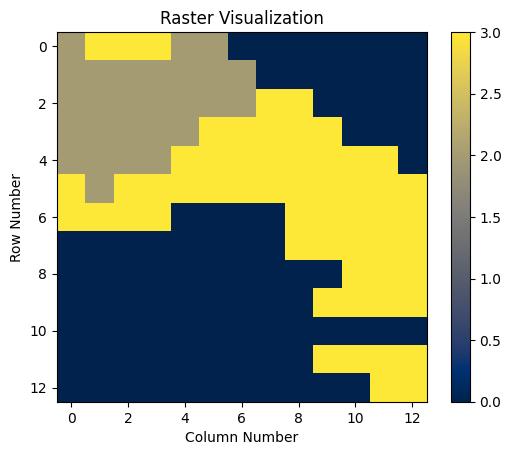

In [9]:
raster_file = 'output_raster_5_145.tif'

with rasterio.open(raster_file) as src:
    raster = src.read(1)

    # Mostrar el raster usando matplotlib
    plt.imshow(raster, cmap='cividis')
    plt.colorbar()
    plt.title('Raster Visualization')
    plt.xlabel('Column Number')
    plt.ylabel('Row Number')
    crs = src.crs
    epsg = crs.to_epsg()
    
    unique_values = np.unique(raster)

    print(f'Valores únicos del raster: {unique_values}')
    print(f'EPSG del raster: {epsg}')
    
    plt.show()
